In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import gc
gc.enable()
from IPython.display import display 
from xgboost import XGBClassifier
from sklearn import metrics, model_selection
import re
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,classification_report,auc ,precision_recall_curve ,average_precision_score, roc_auc_score,roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
import os

In [2]:
from functools import partial

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns

In [4]:
from hyperopt import  Trials, fmin, hp, tpe 
from sklearn.model_selection import StratifiedKFold
from hyperopt.pyll.base import scope

In [5]:
# path ='../input/instacart-market-basket-analysis/'
path ="../"

## Reading datasets

In [ ]:
dtype = {
    "order_id": 'uint32',
    "user_id": 'uint32',
    "eval_set": 'category',
    "order_number": 'uint8',
    "order_dow": 'uint8',
    "order_hour_of_day": 'uint8',
    "days_since_prior_order": 'float16'
}
order = pd.read_csv(path+"orders.csv", dtype=dtype )
# filling days_since_prior_order as 30 as choosing recent value like 0 means people has bought product recently 
order.days_since_prior_order=order.days_since_prior_order.fillna(30)
order.head()
order.eval_set.replace({'prior':1 , 'train':2 , 'test':3} , inplace =True)
order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,1,2,8,30.0
1,2398795,1,1,2,3,7,15.0
2,473747,1,1,3,3,12,21.0
3,2254736,1,1,4,4,7,29.0
4,431534,1,1,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,1,10,5,18,29.0
3421079,1854736,206209,1,11,4,10,30.0
3421080,626363,206209,1,12,1,12,18.0
3421081,2977660,206209,1,13,1,12,7.0


In [ ]:
dtype = {
    "order_id": 'uint32',
    "product_id": 'uint32',
    "add_to_cart_order": 'uint8',
    "reordered": 'uint8'
}
order_product_train = pd.read_csv(path+"order_products__train.csv" , dtype=dtype  )
order_product_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
dtype = {
    "order_id": 'uint32',
    "product_id": 'uint32',
    "add_to_cart_order": 'uint8',
    "reordered": 'uint8'
}
order_product_prior = pd.read_csv(path+"order_products__prior.csv"  , dtype=dtype )
order_product_prior.head(5)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
dtype = {
    "product_id": 'uint32',
    "product_name": 'category',
    "aisle_id": 'uint16',
    "department_id": 'uint16'
}
product = pd.read_csv(path+"products.csv", dtype=dtype  )
product.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Merging order Prior with order , to get product_id and reordered status of a order
- order_Prior contains order_no and product_no information 
- order contains only order number 

In [ ]:
order_product_prior_ = order_product_prior. merge(order ,on ='order_id' , how ='inner')
order_product_prior_

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,1,3,5,9,8.0
1,2,28985,2,1,202279,1,3,5,9,8.0
2,2,9327,3,0,202279,1,3,5,9,8.0
3,2,45918,4,1,202279,1,3,5,9,8.0
4,2,30035,5,0,202279,1,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,1,24,2,6,21.0
32434485,3421083,11352,7,0,25247,1,24,2,6,21.0
32434486,3421083,4600,8,0,25247,1,24,2,6,21.0
32434487,3421083,24852,9,1,25247,1,24,2,6,21.0


#### Features using user_id
- Each order number is associated with one  order number and order_id 
- (order_id - order_number) --> [(2-3),(3421083 ,24)] 
- Last order number is randomly split to train and test sets
- Order_number - max number of orders by user - last order no 
- ttl_cnt_product_user - total order made by user 


In [ ]:
user_feature =order_product_prior_.groupby('user_id')['order_number'].agg(['max' , 'count' ]).reset_index()
user_feature.rename(columns={'max':'order_number' ,'count':'ttl_cnt_product_user'} , inplace =True)
display(user_feature)

,user_id,order_number,ttl_cnt_product_user
0,1,10,59
1,2,14,195
2,3,12,88
3,4,5,18
4,5,4,37
...,...,...,...
206204,206205,3,32
206205,206206,67,285
206206,206207,16,223
206207,206208,49,677


#### Average number of product bought by user per order
- get count of product in an order by user than find  mean count of product bought by user  
- Avg_no_prod_perOrder -Average number of product bought by user

In [ ]:
# get count of product in an order by user
user_prod_cnt=order_product_prior_[['user_id','order_id','product_id']].groupby(['user_id','order_id'])['product_id'].agg(['count']).reset_index()
display(user_prod_cnt)
# get mean count of product bought by user  
user_prod_avg=user_prod_cnt.groupby('user_id')['count'].agg('mean').reset_index()
user_prod_avg.rename(columns={'count':'Avg_no_prod_perOrder'} , inplace =True)
display(user_prod_avg)

,user_id,order_id,count
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
...,...,...,...
3214869,206209,2307371,3
3214870,206209,2558525,3
3214871,206209,2977660,9
3214872,206209,3154581,13


,user_id,Avg_no_prod_perOrder
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000
...,...,...
206204,206205,10.666667
206205,206206,4.253731
206206,206207,13.937500
206207,206208,13.816327


 - days_since_prior_order :Average no of days since user made prior order 

In [ ]:
usr_avg_dspo=order_product_prior_[['user_id' ,'days_since_prior_order']].groupby('user_id')['days_since_prior_order'].agg('mean').reset_index()
display(usr_avg_dspo)

,user_id,days_since_prior_order
0,1,21.078125
1,2,16.906250
2,3,13.593750
3,4,18.609375
4,5,19.109375
...,...,...
206204,206205,25.625000
206205,206206,4.406250
206206,206207,16.500000
206207,206208,7.843750


- Take mode of dow and get which day of week most order is made
- Day of week on which user makes most order 

In [ ]:
usr_dow_max=order_product_prior_[['user_id' ,'order_dow']].groupby('user_id')['order_dow'].agg([lambda x:x.value_counts().index[0]]).reset_index()
usr_dow_max.rename(columns={'<lambda>':'max_dow'} , inplace =True)
display(usr_dow_max)

,user_id,max_dow
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3
...,...,...
206204,206205,4
206205,206206,0
206206,206207,1
206207,206208,2


- Take mode of doh and get which day of hour most order is made
- which hour of day user makes most order
- max_hour_of_day


In [ ]:
usr_hod_max=order_product_prior_[['user_id' ,'order_hour_of_day']].groupby('user_id')['order_hour_of_day'].agg([lambda x:x.value_counts().index[0]]).reset_index()
usr_hod_max.rename(columns={'<lambda>':'max_hour_of_day'} , inplace =True)
display(usr_hod_max)

,user_id,max_hour_of_day
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18
...,...,...
206204,206205,12
206205,206206,18
206206,206207,12
206207,206208,15


- How often does user reorder
- usr_ro_ratio : User reorder ratio

In [ ]:
usr_ro_ratio=order_product_prior_[['user_id' ,'reordered']].groupby('user_id')['reordered'].agg('mean').reset_index()
usr_ro_ratio.rename(columns={'reordered':'usr_ro_ratio'} , inplace =True)
display(usr_ro_ratio)

,user_id,usr_ro_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378
...,...,...
206204,206205,0.250000
206205,206206,0.473684
206206,206207,0.587444
206207,206208,0.707533


- Merging all feature created 

In [ ]:
user_feature=user_feature.merge(user_prod_avg  , on='user_id' , how ='left')
user_feature=user_feature.merge(usr_avg_dspo  , on='user_id' , how ='left')
user_feature=user_feature.merge(usr_hod_max  , on='user_id' , how ='left')
user_feature=user_feature.merge(usr_ro_ratio  , on='user_id' , how ='left')
user_feature=user_feature.merge(usr_dow_max  , on='user_id' , how ='left')
display(user_feature)
del [user_prod_avg ,usr_avg_dspo ,usr_hod_max ,usr_dow_max,usr_ro_ratio]
gc.collect()

,user_id,order_number,ttl_cnt_product_user,Avg_no_prod_perOrder,days_since_prior_order,max_hour_of_day,usr_ro_ratio,max_dow
0,1,10,59,5.900000,21.078125,7,0.694915,4
1,2,14,195,13.928571,16.906250,9,0.476923,2
2,3,12,88,7.333333,13.593750,16,0.625000,0
3,4,5,18,3.600000,18.609375,15,0.055556,4
4,5,4,37,9.250000,19.109375,18,0.378378,3
...,...,...,...,...,...,...,...,...
206204,206205,3,32,10.666667,25.625000,12,0.250000,4
206205,206206,67,285,4.253731,4.406250,18,0.473684,0
206206,206207,16,223,13.937500,16.500000,12,0.587444,1
206207,206208,49,677,13.816327,7.843750,15,0.707533,2


23

- Creating Product Features 
- product_name_length
- isglutenfree
- isOrganic

In [ ]:
product_fe = product.copy()

#Product name length
product_fe['product_name_length'] = product_fe['product_name'].str.len()


def isglutenfree(pname):
    """
    pname: Product name string 
    This function matches is product name contains gluten free in string return true else false
    """
    if re.match(r'(.*gluten.*free)' ,pname ,re.I):
        return 1
    else :
        return 0 
    
product_fe['isglutenfree']=product_fe['product_name'].apply(isglutenfree)

def isOrganic(pname):
    """
    pname: Product name string 
    This function matches is product name contains organic in string return true else false
    """
    if re.match(r'(.*organic.*)' ,pname ,re.I):
        return 1 
    else :
        return 0 
    
product_fe['is_organic']=product_fe['product_name'].apply(isOrganic)
product_fe.drop(columns=['product_name' ,'aisle_id'] , inplace =True)

print("Table product_fe")
display(product_fe)

Table product_fe


,product_id,department_id,product_name_length,isglutenfree,is_organic
0,1,19,26,0,0
1,2,13,16,0,0
2,3,7,36,0,0
3,4,1,65,0,0
4,5,13,25,0,0
...,...,...,...,...,...
49683,49684,5,41,0,0
49684,49685,1,34,0,0
49685,49686,3,16,0,0
49686,49687,8,42,0,0


In [ ]:
del [product,order_product_prior,order_product_prior_,order_product_train , order ]
gc.collect()

20

In [ ]:
# reading order and product prior
dtype = {
    "order_id": 'uint32',
    "user_id": 'uint32',
    "eval_set": 'category',
    "order_number": 'uint8',
    "order_dow": 'uint8',
    "order_hour_of_day": 'uint8',
    "days_since_prior_order": 'float16'
}
order = pd.read_csv(path+"orders.csv", dtype=dtype ,usecols=['order_id' , "user_id" ,'order_number'] )
print("Order Table : ")
display(order)


dtype = {
    "order_id": 'uint32',
    "product_id": 'uint32',
    "add_to_cart_order": 'uint8',
    "reordered": 'uint8',

}

order_product_prior = pd.read_csv(path+"order_products__prior.csv"  , dtype=dtype )
print("Order product Prior Table : ")
display(order_product_prior)

Order Table : 


,order_id,user_id,order_number
0,2539329,1,1
1,2398795,1,2
2,473747,1,3
3,2254736,1,4
4,431534,1,5
...,...,...,...
3421078,2266710,206209,10
3421079,1854736,206209,11
3421080,626363,206209,12
3421081,2977660,206209,13


Order product Prior Table : 


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [ ]:
# merging product prior with order to get user_id
order_product_prior_ = pd.merge(order_product_prior , order , how ="inner" , on="order_id")
# Getting the reorder status of last ordered product by user
prior_last_order = order_product_prior_.groupby("user_id")["order_number"].aggregate("max").reset_index()
# merging product prior to get  user_id 
# lastest order number can belong to train or test points
order_prior_latest=pd.merge(order_product_prior_ ,prior_last_order , on =['user_id' ,'order_number'] , how='inner' )
order_prior_latest=order_prior_latest[["user_id", "product_id", "reordered"]]
# reordered_last if last order was ordered or not 
order_prior_latest.rename(columns={'reordered' :'reordered_last'} , inplace =True)
display(order_prior_latest)

,user_id,product_id,reordered_last
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0
...,...,...,...
2139783,79937,23400,0
2139784,79937,39812,0
2139785,79937,15795,0
2139786,103510,49187,0


- ur_pr_count : sum of product reordered by user 
- ur_pr_reordered : count of product ordered by user

In [ ]:
# getting count of product bought and its reorder count
order_product_prior_=order_product_prior_.groupby(['user_id' ,'product_id'])['reordered'].agg(['count' ,'sum']).reset_index()
order_product_prior_.rename(columns={'count' :'ur_pr_count' , 'sum' :'ur_pr_reordered'} ,inplace =True)

order_product_prior_=pd.merge(order_product_prior_,order_prior_latest ,on= ['user_id' ,'product_id'] , how ='left')
display(order_product_prior_)

,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0
...,...,...,...,...,...
13307948,206209,43961,3,2,NaN
13307949,206209,44325,1,0,NaN
13307950,206209,48370,1,0,NaN
13307951,206209,48697,1,0,NaN


#### Reading order product train 
-  This will let us know product_id for train data 

In [ ]:
#  droping order_number
order.drop(columns =['order_number'] , inplace =True)

# reading order product prior 
dtype = {
    "order_id": 'uint32',
    "product_id": 'uint32',
    "add_to_cart_order": 'uint8',
    "reordered": 'uint8',

}

order_product_train = pd.read_csv(path+"order_products__train.csv"  , dtype=dtype  , usecols=['order_id'])

# grouping by order_id to get order number of product_id in train
order_product_train=order_product_train.groupby('order_id').agg('count').reset_index()

print("Order product train  Table : ")
display(order_product_train)

Order product train  Table : 


,order_id
0,1
1,36
2,38
3,96
4,98
...,...
131204,3421049
131205,3421056
131206,3421058
131207,3421063


### Now getting order_id and user id for train and test data
- For test data order using submission csv 
- For train data using order_products__train
- Later we will merge with order_product_prior_ to get specific feature for test and train data

In [ ]:
# reading test data 
dtype = {
    "order_id": 'uint32'
}

# test =pd.read_csv("../input/pcamarket-analysis/sample_submission.csv" ,dtype =dtype, usecols=['order_id'])
test =pd.read_csv("../sample_submission.csv" ,dtype =dtype, usecols=['order_id'])

# merging with order to get user_id, order_id
train=pd.merge(order_product_train ,order , how ='inner' , on =['order_id'] )
# merging with order to get user_id
test=pd.merge(test ,order , how ='inner' , on =['order_id'] )

print("Train table ")
display(train)
print("Test table ")
display(test)

Train table 


,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463
...,...,...
131204,3421049,189544
131205,3421056,83898
131206,3421058,136952
131207,3421063,169679


Test table 


,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581
...,...,...
74995,3420740,195822
74996,3420877,15955
74997,3420888,162374
74998,3420989,109358


### train and test table

In [ ]:
train =pd.merge(train ,order_product_prior_ , how='inner', on ='user_id' )
test =pd.merge(test ,order_product_prior_ , how='inner', on ='user_id' )
print("Train table")
display(train)
print("Test table")
display(test)
del [order_product_prior_ ,order_prior_latest ,prior_last_order]
gc.collect()

Train table


,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN
...,...,...,...,...,...,...
8474656,3421070,139822,31506,1,0,NaN
8474657,3421070,139822,34035,1,0,NaN
8474658,3421070,139822,35347,1,0,NaN
8474659,3421070,139822,35951,5,4,NaN


Test table


,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0
...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN
4833288,3421054,153585,47145,1,0,NaN
4833289,3421054,153585,47226,1,0,NaN
4833290,3421054,153585,48790,2,1,NaN


20

In [ ]:
# reading product table
dtype = {
    "product_id": 'uint32',
    "product_name": 'category',
    "aisle_id": 'uint16',
    "department_id": 'uint16',

}

product = pd.read_csv(path+"products.csv", dtype=dtype  )
print("Product table")
display(product)

Product table


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [ ]:
# merging train and test dataset with product to get product name 
train=pd.merge(train , product , how ='inner' , on ='product_id')

print("Train table")
display(train)
test=pd.merge(test , product , how ='inner' , on ='product_id')

print("Test table")
display(test)
del product 
gc.collect()

Train table


,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last,product_name,aisle_id,department_id
0,1,112108,2067,1,0,NaN,Plus Cranberry Almond + Antioxidants with Maca...,3,19
1,96,17227,2067,1,0,NaN,Plus Cranberry Almond + Antioxidants with Maca...,3,19
2,3243,206024,2067,1,0,NaN,Plus Cranberry Almond + Antioxidants with Maca...,3,19
3,12950,11456,2067,1,0,0.0,Plus Cranberry Almond + Antioxidants with Maca...,3,19
4,17683,177724,2067,1,0,NaN,Plus Cranberry Almond + Antioxidants with Maca...,3,19
...,...,...,...,...,...,...,...,...,...
8474656,3417483,88512,13705,1,0,NaN,Yoga Bath Soak,109,11
8474657,3418547,187144,22747,1,0,NaN,Vanilla Bean Sheep Milk Ice Cream,37,1
8474658,3418573,117202,25184,2,1,NaN,PeroxiClear Lens Solution,44,11
8474659,3419273,47713,38623,2,1,NaN,"Wild Rice, 100% Natural",4,9


Test table


,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last,product_name,aisle_id,department_id
0,17,36855,1283,1,0,NaN,Organic Edamame & Mung Bean Fettuccine,100,21
1,657743,16994,1283,1,0,NaN,Organic Edamame & Mung Bean Fettuccine,100,21
2,834223,92628,1283,1,0,NaN,Organic Edamame & Mung Bean Fettuccine,100,21
3,1446886,75870,1283,1,0,NaN,Organic Edamame & Mung Bean Fettuccine,100,21
4,1518981,118458,1283,3,2,NaN,Organic Edamame & Mung Bean Fettuccine,100,21
...,...,...,...,...,...,...,...,...,...
4833287,3418159,104905,24836,1,0,NaN,"Cat Litter, Scoopable, Scented",41,8
4833288,3418520,88900,8102,2,1,NaN,"Naty Diapers Size 1, 8-14 lbs",56,18
4833289,3418520,88900,41872,2,1,NaN,"Herbal Tea, Organic Chamomile",94,7
4833290,3419574,1743,18920,1,0,NaN,Turtle Sundae Mix,103,19


0

### reading order_products__train to get reorder status for each entries 

In [ ]:
dtype = {
    "order_id": 'uint32',
    "product_id": 'uint32',
    "add_to_cart_order": 'uint8',
    "reordered": 'uint8',

}

train_target = pd.read_csv(path+"order_products__train.csv" , dtype=dtype ,usecols=['order_id' ,'product_id','reordered'] )
print("train_target table:")
display(train_target)

train_target table:


,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1
...,...,...,...
1384612,3421063,14233,1
1384613,3421063,35548,1
1384614,3421070,35951,1
1384615,3421070,16953,1


In [ ]:
train_target = pd.merge(train_target , order , on ='order_id' , how ='inner')
train_target =train_target[["user_id", "product_id", "reordered"]]
print("train_target table:")
display(train_target)

train_target table:


,user_id,product_id,reordered
0,112108,49302,1
1,112108,11109,1
2,112108,10246,0
3,112108,49683,0
4,112108,43633,1
...,...,...,...
1384612,169679,14233,1
1384613,169679,35548,1
1384614,139822,35951,1
1384615,139822,16953,1


In [ ]:
train=pd.merge(train , train_target , how='left' , on=["user_id", "product_id"])
train['reordered'].fillna(0 , inplace =True) 

print("Train table:")
display(train_target)

del train_target 
gc.collect()

Train table:


,user_id,product_id,reordered
0,112108,49302,1
1,112108,11109,1
2,112108,10246,0
3,112108,49683,0
4,112108,43633,1
...,...,...,...
1384612,169679,14233,1
1384613,169679,35548,1
1384614,139822,35951,1
1384615,139822,16953,1


60

### Prepare dataset

#### we have no idea if product is reordered or not for many product 
- 1- reordered 
- 0- not reordered
- 3 - no idea

In [ ]:
train.reordered_last.fillna(3,inplace =True)
test.reordered_last.fillna(3,inplace =True)

In [ ]:
# droping product as we have product_name  
train.drop(columns='product_name' , inplace =True)
test.drop(columns='product_name' , inplace =True)

### merging feature engineered columns 

In [ ]:
# merge train and test  with user_feature
train=train.merge(user_feature  , on='user_id' , how='left')
# droping department_id as it is redundant
product_fe.drop(columns='department_id' , inplace =True)
# merge train and test  with product_fe
train=train.merge(product_fe  , on='product_id' , how='left')

In [ ]:
train

,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last,aisle_id,department_id,reordered,order_number,ttl_cnt_product_user,Avg_no_prod_perOrder,days_since_prior_order,max_hour_of_day,usr_ro_ratio,max_dow,product_name_length,isglutenfree,is_organic
0,1,112108,2067,1,0,3.0,3,19,0.0,3,21,7.000000,17.671875,10,0.428571,1,60,0,0
1,96,17227,2067,1,0,3.0,3,19,0.0,6,43,7.166667,21.531250,18,0.232558,1,60,0,0
2,3243,206024,2067,1,0,3.0,3,19,0.0,42,335,7.976190,6.648438,8,0.620896,5,60,0,0
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,168,18.666667,12.203125,20,0.547619,2,60,0,0
4,17683,177724,2067,1,0,3.0,3,19,0.0,29,396,13.655172,14.695312,14,0.608586,6,60,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3417483,88512,13705,1,0,3.0,109,11,0.0,4,39,9.750000,23.796875,20,0.230769,6,14,0,0
8474657,3418547,187144,22747,1,0,3.0,37,1,0.0,49,890,18.163265,5.964844,20,0.823596,0,33,0,0
8474658,3418573,117202,25184,2,1,3.0,44,11,0.0,7,31,4.428571,22.453125,9,0.161290,2,25,0,0
8474659,3419273,47713,38623,2,1,3.0,4,9,0.0,6,109,18.166667,12.367188,15,0.412844,6,23,0,0


In [ ]:
# merge train and test  with user_feature
test=test.merge(user_feature  , on='user_id' , how='left')
# merge train and test  with product_fe
test=test.merge(product_fe  , on='product_id' , how='left')

In [ ]:
test

,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last,aisle_id,department_id,order_number,ttl_cnt_product_user,Avg_no_prod_perOrder,days_since_prior_order,max_hour_of_day,usr_ro_ratio,max_dow,product_name_length,isglutenfree,is_organic
0,17,36855,1283,1,0,3.0,100,21,4,27,6.750000,18.437500,9,0.222222,0,38,0,1
1,657743,16994,1283,1,0,3.0,100,21,9,61,6.777778,12.820312,20,0.344262,4,38,0,1
2,834223,92628,1283,1,0,3.0,100,21,14,333,23.785714,11.789062,7,0.639640,0,38,0,1
3,1446886,75870,1283,1,0,3.0,100,21,21,241,11.476190,10.164062,10,0.609959,1,38,0,1
4,1518981,118458,1283,3,2,3.0,100,21,14,124,8.857143,14.304688,11,0.362903,6,38,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3418159,104905,24836,1,0,3.0,41,8,15,297,19.800000,14.976562,10,0.363636,0,30,0,0
4833288,3418520,88900,8102,2,1,3.0,56,18,75,661,8.813333,5.484375,18,0.695915,1,29,0,0
4833289,3418520,88900,41872,2,1,3.0,94,7,75,661,8.813333,5.484375,18,0.695915,1,29,0,1
4833290,3419574,1743,18920,1,0,3.0,103,19,36,176,4.888889,8.906250,17,0.414773,2,17,0,0


### Using idf to fing rare products 

In [ ]:
# getting Tfidf reperesentation of product id  to find rare product 
tfidf_prod=TfidfVectorizer(min_df=10)
tfidf_prod.fit(train['product_id'].astype('str'))

TfidfVectorizer(min_df=10)

In [ ]:
# creating dictionary of feature and its idf score 
product_idf=dict(zip(tfidf_prod.get_feature_names(),tfidf_prod.idf_))

# product who has idf score more than 90 percentile is taken as rare 
rare_idf_value =np.percentile(tfidf_prod.idf_ , 90)

def idfmap(dictionary , value , rare_idf_value):
    """
    dictionary : feature and idf map 
    value : value at particular index
    rare_idf_value : rare idf value if idf score is greater than 90 percentile its rare 
    """
    if dictionary.get(value):
        if dictionary.get(value)>= rare_idf_value :
            return 1
        else:
            return 0
    # if no value is found in dictionary return 0 
    else:
        return 0

In [ ]:
train['product_is_rare']=train['product_id'].apply(lambda prd : idfmap(product_idf , str(prd) ,rare_idf_value))
test['product_is_rare']=test['product_id'].apply(lambda prd : idfmap(product_idf , str(prd) ,rare_idf_value))

In [ ]:
del [tfidf_prod ,rare_idf_value ,product_idf]
del [user_feature ,product_fe ,order]
gc.collect()

40

In [ ]:
# saving dataset for future operations
train.to_parquet('train.gzip',compression='gzip')
test.to_parquet('test.gzip',compression='gzip')

# Reading train and test data 

In [11]:
#aaaa
# dir ='/content/drive/MyDrive/instacart/'
dir ='train_test_data/'

In [12]:
train =pd.read_parquet(dir+'train.gzip')
print(train.shape)
# train = train.sample(400000, random_state=1)
# print("Sampling 400000 rows")
# print(train.shape)

(8474661, 20)


In [13]:
train.head()

,order_id,user_id,product_id,ur_pr_count,ur_pr_reordered,reordered_last,aisle_id,department_id,reordered,order_number,ttl_cnt_product_user,Avg_no_prod_perOrder,days_since_prior_order,max_hour_of_day,usr_ro_ratio,max_dow,product_name_length,isglutenfree,is_organic,product_is_rare
index,,,,,,,,,,,,,,,,,,,,
0,1,112108,2067,1,0,3.0,3,19,0.0,3,21,7.000000,17.671875,10,0.428571,1,60,0,0,0
1,96,17227,2067,1,0,3.0,3,19,0.0,6,43,7.166667,21.531250,18,0.232558,1,60,0,0,0
2,3243,206024,2067,1,0,3.0,3,19,0.0,42,335,7.976190,6.648438,8,0.620896,5,60,0,0,0
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,168,18.666667,12.203125,20,0.547619,2,60,0,0,0
4,17683,177724,2067,1,0,3.0,3,19,0.0,29,396,13.655172,14.695312,14,0.608586,6,60,0,0,0


In [8]:
# train['reordered_last']=train['reordered_last'].astype(np.int8) 
# train['max_hour_of_day']=train['max_hour_of_day'].astype(np.int8) 
# train['max_dow']=train['max_dow'].astype(np.int8) 

In [14]:
train.columns

Index(['order_id', 'user_id', 'product_id', 'ur_pr_count', 'ur_pr_reordered',
       'reordered_last', 'aisle_id', 'department_id', 'reordered',
       'order_number', 'ttl_cnt_product_user', 'Avg_no_prod_perOrder',
       'days_since_prior_order', 'max_hour_of_day', 'usr_ro_ratio', 'max_dow',
       'product_name_length', 'isglutenfree', 'is_organic', 'product_is_rare'],
      dtype='object')

### checking correlation 

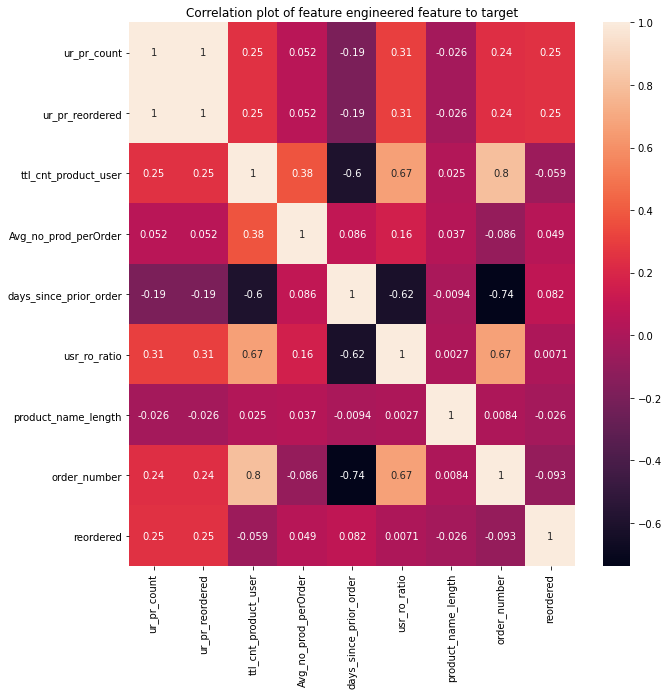

In [10]:
numerical_feature=['ur_pr_count' ,'ur_pr_reordered'  ,'ttl_cnt_product_user', 'Avg_no_prod_perOrder',
       'days_since_prior_order','usr_ro_ratio','product_name_length','order_number' ,'reordered']
plt.figure(figsize=(10,10))
sns.heatmap(train.loc[:,numerical_feature].corr(), annot=True)
plt.title("Correlation plot of feature engineered feature to target")
plt.show()

- Removing ur_pr_count as it is highly correlated to one another - correlated feature do not add much information as they can be formed by  linear combination of each other.

In [15]:
# saving train target 
y = train.reordered.values
# test_temp = test[["order_id", "product_id"]]
# droping ids 
train.drop(columns =["order_id", "user_id", "reordered" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count']  , inplace =True)
# test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id'] , inplace =True)


In [16]:
print("Train shape " ,train.shape)
# print("Test shape " ,test.shape)

Train shape  (8474661, 13)


## Split data

In [70]:
# !pip install category_encoders

In [19]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, test_size=0.2)

In [20]:
from sklearn.preprocessing import StandardScaler
test_preprocessing_object ={}
def standardize(X_train, X_test ,test_preprocessing_object , flag ='train'):
    """
    This function standardize test and train columns if flag is train standization will fit and trainsform 
    if test it will just standardize.
    returns train ,test and  test_preprocessing_object if flag is train else test data and test_preprocessing_object
    X_train : train data
    X_test  :test data 
    test_preprocessing_object : dictionary containing object of columns transformer for different column 
    flag : string either train or test 
    """
    std_columns =['ur_pr_reordered','order_number','ttl_cnt_product_user','Avg_no_prod_perOrder','days_since_prior_order','usr_ro_ratio','product_name_length']
    scaler_objects =[]

    if(flag == 'train'):
        for col in std_columns:
            print(col)
            scaler = StandardScaler()
            scaler.fit(X_train.loc[:,col].values.reshape(-1,1))
            X_train.loc[:,col] =scaler.transform(X_train.loc[:,col].values.reshape(-1,1))
            X_test.loc[:,col] =scaler.transform(X_test.loc[:,col].values.reshape(-1,1))
            scaler_objects.append({col:scaler})
            del scaler
            gc.collect()
        test_preprocessing_object['std']=scaler_objects
    elif(flag =='test'):
        for item in test_preprocessing_object['std']:
            for col_item in item.items():
                col =col_item[0]
                scaler=col_item[1]
                print(col)
                X_test.loc[:,col] =scaler.transform(X_test.loc[:,col].values.reshape(-1,1))
    if(flag=='train'):
        return X_train.copy() , X_test.copy() ,test_preprocessing_object
    else:
        return X_test.copy() ,test_preprocessing_object
            
    

    
def OHE(xtrain, column , xtest ):
    """
    This function One hot encode train and test data 
    retruns encoded train and test data and encoder object
    xtrain : train data
    column : list of columns to apply encoding 
    xtest  : test data 
    """
    xtrain = xtrain.reset_index(drop=True)
    xtest =xtest.reset_index(drop =True)
    print("Before")
    print(xtrain.shape)
    print(xtest.shape)
    enc = OneHotEncoder(handle_unknown='ignore' ,sparse=False)
    print("Column name ", column)
    #Train encoding 


    temp_train_ohe=enc.fit_transform(xtrain.loc[:,column].values.reshape(-1 ,1))
    # create column_name
    col_name=[column+"_"+str(i+1) for i in range(temp_train_ohe.shape[1])]
    # defining data type    
    datatype ={ i:'bool' for i in col_name}
    temp_train_ohe = pd.DataFrame(temp_train_ohe ,columns=col_name )
    xtrain.drop(columns=column , inplace =True)
    new_train =pd.concat([xtrain,temp_train_ohe],axis=1)
    
    temp_test_ohe=enc.fit_transform(xtest.loc[:,column].values.reshape(-1 ,1))
    xtest.drop(columns=column , inplace =True)
    
    temp_test_ohe = pd.DataFrame(temp_test_ohe ,columns=col_name)
    
    new_test =pd.concat([xtest,temp_test_ohe] , axis =1)
    print("After")
    print(new_train.shape)
    print(new_test.shape)
    
    return new_train.copy() , new_test.copy(),enc

def ohe_Test(test , test_preprocessing_object ):
    """
    This function transform test data to one hot encoding
    return transformed test data
    test :test data
    test_preprocessing_object:dictionary containing object of columns transformer for different column 
    """
    test =test.reset_index(drop =True)
    ohe=test_preprocessing_object['OHE']
    for column in ohe:
        ohe_encoder = ohe[column]
        temp_test_ohe=ohe_encoder.transform(test.loc[:,column].values.reshape(-1 ,1))
        print(temp_test_ohe.shape)
        col_name=[column+"_"+str(i+1) for i in range(temp_test_ohe.shape[1])]
        # defining data type    
        datatype ={ i:'bool' for i in col_name}
        temp_test_ohe = pd.DataFrame(temp_test_ohe ,columns=col_name )
        test.drop(columns=column , inplace =True)
        new_test =pd.concat([test,temp_test_ohe] , axis =1)
        test =new_test.copy()
        
    return test




In [21]:
# Standardizing numerical data
X_train, X_test ,test_preprocessing_object=standardize(X_train, X_test ,test_preprocessing_object , flag ='train')

ur_pr_reordered


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


order_number


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ttl_cnt_product_user


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Avg_no_prod_perOrder


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


days_since_prior_order


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


usr_ro_ratio


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


product_name_length


/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/aditya/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
def response_code_train(X_train,y_train ,X_test  ):
    
  
    '''
  This function response code categorical varible
  X_train : train data 
  y_ train : train label 
  X_test: test data 
  retruns transformed train , test data along Target encoder object to apply it on test data to fit transform test.
  '''

    response_column =['max_hour_of_day' ,'reordered_last','max_dow']
    reponse_dict ={}

    for col in response_column:
      print(col)
      encoder=ce.TargetEncoder(cols=col)
            
      X_train.loc[:,col] =encoder.fit_transform(X_train[col] , y_train)
      X_test.loc[:,col] =encoder.transform(X_test[col])
      reponse_dict[col]=encoder
      del encoder
      gc.collect()
    return X_train.copy() , X_test.copy() ,reponse_dict



def response_code_test( X_test ,response_dict):
    """
    This function takes data and does fit transform based on column wise,
    according to column specific encoder stored in reponse_dctionary 
    X_test : test data 
    response_dict : dictionary containing encoder object 
    return transformed test data 
    """

    response_column =['max_hour_of_day' ,'reordered_last','max_dow']
    for col in response_column:
        encoder =response_dict[col]
        X_test.loc[:,col] =encoder.transform(X_test.loc[:,col])


    
    return X_test.copy()
            
            

In [28]:
X_train , X_test ,reponse_dict =response_code_train(X_train,y_train ,X_test  )

max_hour_of_day


/home/aditya/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


reordered_last


/home/aditya/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


max_dow


/home/aditya/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
del train 
gc.collect()

20

In [ ]:
# # transforming train test data 
# X_train , X_test , ohe_rl =OHE(X_train,'reordered_last' , X_test )
# X_train , X_test ,ohe_rl_mhod=OHE(X_train,'max_hour_of_day' , X_test )
# test_preprocessing_object['OHE']={'reordered_last' :ohe_rl ,'max_hour_of_day' :ohe_rl_mhod}

# Compute model Performance
- Key performance criterion F1 score
- we  want false positive rate to be very low and Tpr to be high 
- We wont be relying to much on AUC because of class imbalance 
- We will be more intresting in optimizing precsion and recall 

In [30]:
def recall_score(tp ,fn ):
    return (tp)/(tp+fn)
def precision_score(tp ,fp):
    return (tp)/(tp+fp)
def f1_score_score(precision ,recall):
    return 2*((precision * recall)/(precision + recall))
def accuracy_score(tp, tn , fp ,fn):
    return (tp+tn)/(tp+tn+fp+fn)
def tpr_score(tp ,fn ):
    return (tp)/(tp+fn)
def fpr_score(fp ,tn ):
    return (fp)/(fp+tn)
def fnr_score(fn ,tp ):
    return (fn)/(fn+tp)
def tnr_score(fp ,tn ):
    return (tn)/(tn+fp)
_
def modelPerformance(tp , tn , fn , fp):
    """
    printing tpr,fpr ,tnr, precision , recall and f1 score 
    tp:true positive 
    tn: true negative 
    fn : false negative
    fp : false positive
    """
    print("Accuracy" ,((tp+tn)/(tp+tn+fp+fn)))
    print("True positive rate " ,tpr_score(tp ,fn ))
    print("False positive rate " ,fpr_score(fp ,tn ))
    print("False negative  rate " ,fnr_score(fn ,tp ))
    print("True negative  rate " ,tnr_score(fp ,tn ))
    print("Precision " ,precision_score(tp ,fp))
    print("Recall" ,recall_score(tp ,fn ))
    print("F1 rate" ,f1_score_score(precision_score(tp ,fp),recall_score(tp ,fn )))
    


def printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  ):
    """
    printing model performance 
    y_train : True train target 
    y_test : True test target 
    y_train_pred : Train prediction
    y_test_pred : test prediction
    """
    print("Model Performance")
    print("Train: ")
    tn, fp, fn, tp=confusion_matrix(y_train ,y_train_pred ).ravel()
    modelPerformance(tp , tn , fn , fp)
    print("Test: ")
    tn, fp, fn, tp=confusion_matrix(y_test ,y_test_pred ).ravel()
    modelPerformance(tp , tn , fn , fp)

def plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Decision Tree AUC-ROC curve"):
    """
    Plot AUC-ROC curve 
    y_train : True train target 
    y_train_proba: positive class probality
    title : title of plot 
    """
    fpr , tpr , threshold=roc_curve(y_train ,y_train_proba )
    print("\nAUC score " , auc(fpr , tpr))
    plt.plot([0,1], [0,1], linestyle='-.', label='No Skill')
    plt.plot(fpr , tpr ,linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_Precision_Recall(y_train ,y_train_proba ,title="Decision Tree Precision-Recall curve"):
    """
    Plot Precision-Recall curve 
    y_train : True train target 
    y_train_proba: positive class probality
    title : title of plot 
    """
    precision_ , recall_ , threshold_=precision_recall_curve(y_train ,y_train_proba)
    no_skill =len(y_train[y_train==1])/len(y_train)
    plt.plot([0,1] , [no_skill,no_skill] ,linestyle='-.' , label='noSkill')
    plt.plot(precision_ , recall_ ,linestyle='--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()
    
    
def get_optimal_F1(y_test ,y_test_proba, label="Decision tree Precision recall AUC"):
    """
    This function conputes  optimal F1 score
    retruns optimal threshold
    y_test :True Test target 
    y_test_proba: Positive data probality 
    label: label of plot
    
    """
    precision_ , recall_ , threshold_=precision_recall_curve(y_test ,y_test_proba)
    
    # find f1 score for all thresh 
    fscore = (2 * precision_ * recall_) / (precision_ + recall_)
    # percentage of positive pts in data set 
    no_skill =len(y_test[y_test==1])/len(y_test)
    # get the index which has max f1 score 
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (threshold_[ix], fscore[ix]))
    
    plt.plot([0,1] , [no_skill,no_skill] ,linestyle='--' , label='noSkill')
    plt.plot(precision_ , recall_ ,linestyle=':')
    plt.scatter(recall_[ix], precision_[ix], marker='o', color='black', label='Best')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(label)
    plt.legend()
    plt.show()
    return threshold_[ix]

def Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh ):
    """
    This function prints model preformance credentials after thresholding probality 
    y_train : True train target 
    y_test : True test target 
    y_train_pred : Train prediction
    y_test_pred : test prediction
    thresh :Threshold to convert probality to class
    
    """
    y_train_pred=np.where(y_train_proba<=thresh, 0 , 1 ).tolist()
    y_test_pred =np.where(y_test_proba<=thresh, 0 , 1 ).tolist()
    printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )
    
    
def merge_products(x):
    """
    x : string input
    This function merge group to a list 
    returns list of strings 
    """
    return " ".join(list(x.astype('str')))


def generate_SubmissionCsv(test_sub, pred , thresh):
    """
    This function create submission csv based on prediction by model
    return submission csv 
    test_sub : dataframe containing order_id and product_id
    
    pred:prediction probality of positive class
    
    thresh : optimal threshold to convert probality to class 
    """
    
    # if pobality is greter than threshold predict 1 else 0
    test_sub["Pred"] = np.where(pred>=thresh ,1,0)
    # select all cases where prediction is 1
    test_sub = test_sub.loc[test_sub["Pred"].astype('int')==1]
    #group by order_id and create lsit of products
    test_sub = test_sub.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
    test_sub.columns = ["order_id", "products"]
    # read submission dataframe and merge with test_sub on order_id 
    sub_df = pd.read_csv("../sample_submission.csv", usecols=["order_id"])
    sub_df = pd.merge(sub_df, test_sub, how="left", on="order_id")
    # fill missing product as None 
    sub_df["products"].fillna("None", inplace=True)

    return sub_df

def generate_SubmissionCsv_colob(test_sub, pred , thresh):
    """
    This function create submission csv based on prediction by model
    return submission csv, this is google colab specific function
    test_sub : dataframe containing order_id and product_id
    
    pred:prediction probality of positive class
    
    thresh : optimal threshold to convert probality to class 
    """
    
    # if pobality is greter than threshold predict 1 else 0
    test_sub["Pred"] = np.where(pred>=thresh ,1,0)
    # select all cases where prediction is 1
    test_sub = test_sub.loc[test_sub["Pred"].astype('int')==1]
    #group by order_id and create lsit of products
    test_sub = test_sub.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
    test_sub.columns = ["order_id", "products"]
    # read submission dataframe and merge with test_sub on order_id 
    sub_df = pd.read_csv(dir+"/sample_submission.csv", usecols=["order_id"])
    sub_df = pd.merge(sub_df, test_sub, how="left", on="order_id")
    # fill missing product as None 
    sub_df["products"].fillna("None", inplace=True)

    return sub_df

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

## KNN
- Optimizing Knn

In [ ]:
def optimizeknn(params,X_train =X_train,y_train=y_train):
  kf = StratifiedKFold(n_splits =3)
  knn=KNeighborsClassifier(**params)
    
  f1s =[]
  for idx in kf.split(X=X_train ,y =y_train):
    train_idx , test_idx=idx[0] ,idx[1]
    xtrain =X_train.iloc[train_idx ,:]
    ytrain =y_train[train_idx]

    xtest =X_train.iloc[test_idx ,:]
    ytest =y_train[test_idx]


    knn.fit(xtrain , ytrain )
    
    y_pred_test=knn.predict(xtest)

    f1=f1_score(ytest , y_pred_test)
    print("F1 : ",f1)
    f1s.append(f1)

  return -1.0 *np.mean(f1s)

In [ ]:
# define parameter space

param_space ={
    'n_neighbors' :scope.int(hp.quniform('n_neighbors' ,5 ,50 ,5)),
    'algorithm':hp.choice('algorithm',['ball_tree', 'kd_tree']),
    'metric':hp.choice('metric',["euclidean","manhattan","chebyshev"])
} 

optimization_function = partial(optimizeknn ,X_train =X_train,y_train =y_train)

trail = Trials()

results =fmin(fn =optimization_function , space= param_space , algo =tpe.suggest  , max_evals=5 ,trials=trail, )


In [ ]:
print(results)

{'algorithm': 0, 'metric': 0, 'n_neighbors': 15.0}


In [ ]:
knn=KNeighborsClassifier(algorithm='ball_tree', metric= 'euclidean', n_neighbors= 15 , n_jobs =-1)
knn.fit(X_train , y_train)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_jobs=-1,
                     n_neighbors=15)

In [ ]:
# making prediction
y_train_proba=knn.predict_proba(X_train)[:,1]
y_test_proba=knn.predict_proba(X_test)[:,1]
y_train_pred=np.where(y_train_proba>0.5,1 ,0)
y_test_pred=np.where(y_test_proba>0.5,1 ,0)

Model Performance
Train: 
True positive rate  0.13201957753735188
False positive rate  0.007364748878675453
False negative  rate  0.8679804224626482
True negative  rate  0.9926352511213246
Precision  0.6583172768143867
Recall 0.13201957753735188
F1 rate 0.2199334835318099
Test: 
True positive rate  0.10819165378670788
False positive rate  0.009192092585414475
False negative  rate  0.8918083462132921
True negative  rate  0.9908079074145856
Precision  0.5585106382978723
Recall 0.10819165378670788
F1 rate 0.18126888217522658

AUC score  0.8578968363514758


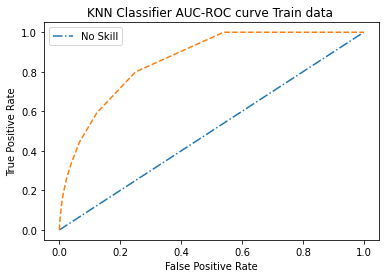


AUC score  0.7220363249785272


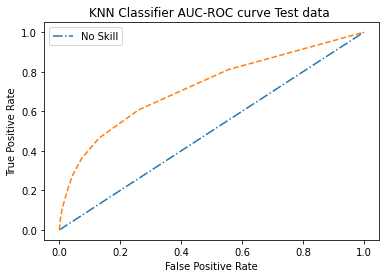

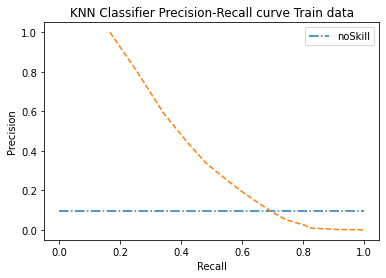

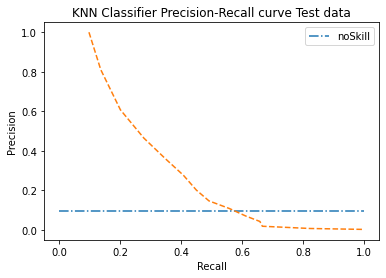

In [ ]:
# printing model performance
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="KNN Classifier AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="KNN Classifier AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="KNN Classifier Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="KNN Classifier Precision-Recall curve Test data")    

Best Threshold=0.266667, F-Score=0.354


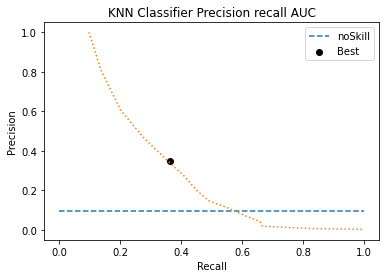

Model Performance
Train: 
True positive rate  0.33887171561051005
False positive rate  0.03928788969488897
False negative  rate  0.66112828438949
True negative  rate  0.9607121103051111
Precision  0.4810751508502468
Recall 0.33887171561051005
F1 rate 0.39764225799138514
Test: 
True positive rate  0.2761463163317877
False positive rate  0.04313638628938479
False negative  rate  0.7238536836682122
True negative  rate  0.9568636137106152
Precision  0.40760456273764256
Recall 0.2761463163317877
F1 rate 0.32923832923832924


In [ ]:
thresh_knn=get_optimal_F1(y_test ,y_test_proba, label="KNN Classifier Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_knn )

In [ ]:
test =pd.read_parquet('test.gzip')

In [ ]:
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]
# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_knn_test =knn.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_knn_test ,thresh_knn)

In [ ]:
# save submission csv
submission_log.to_csv("./submission/knn.csv",index=False)

- Score 
- private :0.30895
- public :0.30967

## SVC
- Tuning SVC

In [ ]:
from  sklearn.svm import SVC

In [ ]:
def optimizesvm(params,X_train =X_train,y_train=y_train):
  kf = StratifiedKFold(n_splits =3)
  svm =SVC(**params)

    
  f1s =[]
  for idx in kf.split(X=X_train ,y =y_train):
    train_idx , test_idx=idx[0] ,idx[1]
    xtrain =X_train.iloc[train_idx ,:]
    ytrain =y_train[train_idx]

    xtest =X_train.iloc[test_idx ,:]
    ytest =y_train[test_idx]


    svm.fit(xtrain , ytrain )
    
    y_pred_test=svm.predict(xtest)

    f1=f1_score(ytest , y_pred_test)
    print(f1)
    f1s.append(f1)

  return -1.0 *np.mean(f1s)    

In [ ]:
# define parameter space
param_space ={
    'C' :hp.uniform('C' ,0.1,200),
    'gamma' :hp.uniform('gamma' ,0.0001,1),
    'kernel':hp.choice('kernel',['rbf' ,'linear' , 'sigmoid']),
} 

optimization_function = partial(optimizesvm ,X_train =X_train,y_train =y_train)

trail = Trials()

results =fmin(fn =optimization_function , space= param_space , algo =tpe.suggest  , max_evals=10 ,trials=trail )
print(results)

- #### Fitting Support Vector Machine with best tuned parameter

In [ ]:
params={'C': 23.708880283620815, 'gamma': 0.09713900631220027, 'kernel': 'sigmoid'}

In [ ]:
svm =SVC(**params ,max_iter =10000 ,probability=True )
svm.fit(X_train , y_train )

SVC(C=23.708880283620815, gamma=0.09713900631220027, kernel='sigmoid',
    max_iter=10000, probability=True)

In [ ]:
# making prediction
y_train_proba=svm.predict_proba(X_train)[:,1]
y_test_proba=svm.predict_proba(X_test)[:,1]
y_train_pred=np.where(y_train_proba>0.5,1 ,0)
y_test_pred=np.where(y_test_proba>0.5,1 ,0)

Model Performance
Train: 
True positive rate  0.02331272539927872
False positive rate  0.002907137715266626
False negative  rate  0.9766872746007212
True negative  rate  0.9970928622847334
Precision  0.4629156010230179
Recall 0.02331272539927872
F1 rate 0.04438994481912937
Test: 
True positive rate  0.024214322514167955
False positive rate  0.002879450689406944
False negative  rate  0.975785677485832
True negative  rate  0.997120549310593
Precision  0.47474747474747475
Recall 0.024214322514167955
F1 rate 0.04607843137254902

AUC score  0.6142299404002891


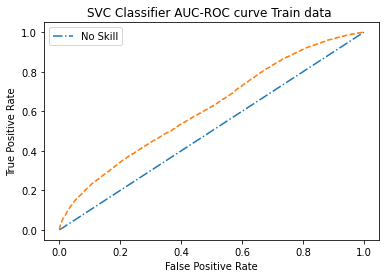


AUC score  0.6133552341844534


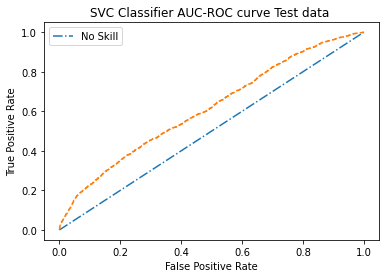

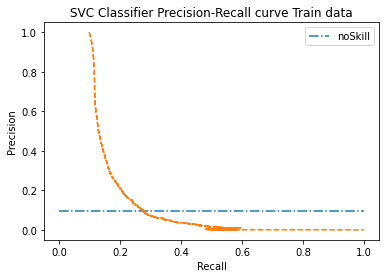

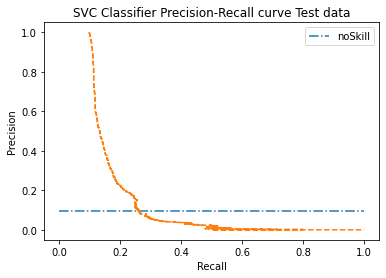

In [ ]:
# printing model performance

printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="SVC Classifier AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="SVC Classifier AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="SVC Classifier Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="SVC Classifier Precision-Recall curve Test data")    

Best Threshold=0.112668, F-Score=0.221


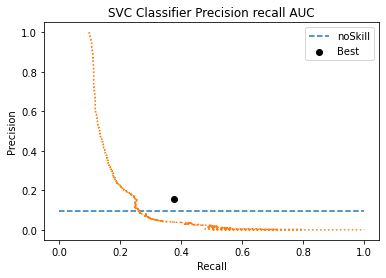

Model Performance
Train: 
True positive rate  0.36501803194229776
False positive rate  0.22103937095077247
False negative  rate  0.6349819680577022
True negative  rate  0.7789606290492276
Precision  0.15073666294346044
Recall 0.36501803194229776
F1 rate 0.21336344814605682
Test: 
True positive rate  0.37609479649665123
False positive rate  0.21911512265352456
False negative  rate  0.6239052035033488
True negative  rate  0.7808848773464755
Precision  0.15574994666097716
Recall 0.37609479649665123
F1 rate 0.22027761013880504


In [ ]:
thresh_SVC=get_optimal_F1(y_test ,y_test_proba, label="SVC Classifier Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_SVC )

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]
# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_svm_test =svm.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
#987

In [ ]:
# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_svm_test ,thresh_SVC)

In [ ]:
submission_log.to_csv("./submission/svc.csv",index=False)

- Score 
- private :0.19827
- public :0.20212

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression 

- Hyperparameter tunning Logistic regression

In [ ]:
distributions = {'penalty':["l1", "l2" ,'elasticnet'],'C': [100, 10, 1.0, 0.1, 0.01] ,'class_weight' :[None ,'balanced'] ,
                 'max_iter' :[10 ,20 ,30 ,40,50,60,70,80,90,100,110]}

In [ ]:
logistic=LogisticRegression()
clf =RandomizedSearchCV(logistic , distributions ,scoring ='f1',n_iter = 30 ,cv =3,verbose=3,return_train_score=True ,n_jobs=-1)
clf.fit(X_train , y_train)

#### Fitting Logistic regression with best tuned parameter

Best parameters 
{'penalty': 'l2', 'max_iter': 30, 'class_weight': 'balanced', 'C': 0.01}

In [ ]:
param ={'penalty': 'l2', 'max_iter': 30, 'class_weight': 'balanced', 'C': 0.01}

In [ ]:
# Training with best parameter
logistic=LogisticRegression(**param)
logistic.fit(X_train , y_train)

/home/aditya/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, class_weight='balanced', max_iter=30)

In [ ]:
# making prediction
y_train_pred=logistic.predict(X_train)
y_test_pred=logistic.predict(X_test)
y_train_proba=logistic.predict_proba(X_train)[:,1]
y_test_proba=logistic.predict_proba(X_test)[:,1]

Model Performance
Train: 
True positive rate  0.619021836669135
False positive rate  0.18649807599528437
False negative  rate  0.380978163330865
True negative  rate  0.8135019240047157
Precision  0.2646011623296878
Recall 0.619021836669135
F1 rate 0.37073253565309133
Test: 
True positive rate  0.6197025910174041
False positive rate  0.18663809339457796
False negative  rate  0.38029740898259584
True negative  rate  0.8133619066054221
Precision  0.26466920536114563
Recall 0.6197025910174041
F1 rate 0.3709213545625403

AUC score  0.7902664066651505


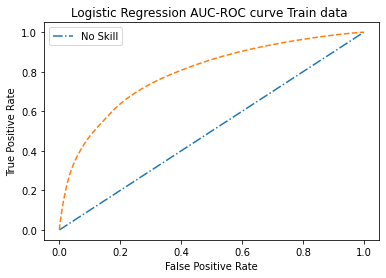


AUC score  0.7908381306504623


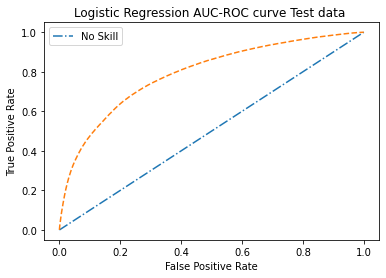

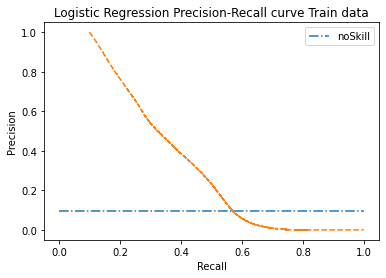

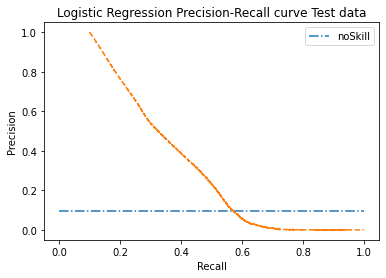

In [ ]:
# printing model performance
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Logistic Regression AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Logistic Regression AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="Logistic Regression Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Logistic Regression Precision-Recall curve Test data")    

- Finding the optimal threshold from precision recall to maximize f1 score

Best Threshold=0.661966, F-Score=0.399


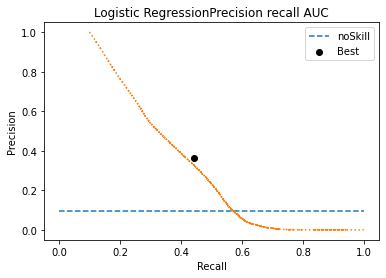

Model Performance
Train: 
True positive rate  0.4401222214011121
False positive rate  0.08382519963071404
False negative  rate  0.5598777785988879
True negative  rate  0.916174800369286
Precision  0.3627171689300212
Recall 0.4401222214011121
F1 rate 0.39768822519771846
Test: 
True positive rate  0.44138388682773805
False positive rate  0.08384690236782355
False negative  rate  0.5586161131722619
True negative  rate  0.9161530976321764
Precision  0.3633194625140281
Recall 0.44138388682773805
F1 rate 0.39856515237765805


In [ ]:
thresh_lr=get_optimal_F1(y_test ,y_test_proba, label="Logistic RegressionPrecision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_lr )

###  Preparing for submission 

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]
# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_logistic_test =logistic.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_logistic_test ,thresh_lr)


In [ ]:
# save submission csv
submission_log.to_csv("./submission/logisticRegression.csv",index=False)

- Score 
- private :0.34327
- public 0.34449

# Naive bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB  , BernoulliNB

- Hyperparamter tunning Gaussion Naive bayes 

In [ ]:
distributions = {'var_smoothing' :list(np.logspace(-9,4, num=20))}
gnb =GaussianNB()
clf =RandomizedSearchCV(gnb , distributions ,scoring ='f1',n_iter = 30 ,cv =3,verbose=3,return_train_score=True ,n_jobs=-1)
clf.fit(X_train , y_train)

- Best hypertunned parameter 
- 'var_smoothing': 0.03359818286283781

- Fitting with best hyperparameter

In [ ]:
gnb =GaussianNB(var_smoothing= 0.03359818286283781)
gnb.fit(X_train , y_train)

GaussianNB(var_smoothing=0.03359818286283781)

In [ ]:
# making prediction
y_train_pred=gnb.predict(X_train)
y_test_pred=gnb.predict(X_test)
y_train_proba=gnb.predict_proba(X_train)[:,1]
y_test_proba=gnb.predict_proba(X_test)[:,1]

Model Performance
Train: 
True positive rate  0.41607760395379595
False positive rate  0.08046045976985186
False negative  rate  0.583922396046204
True negative  rate  0.9195395402301482
Precision  0.3592080558933589
Recall 0.41607760395379595
F1 rate 0.3855570532453167
Test: 
True positive rate  0.4164208367266914
False positive rate  0.0802410199533341
False negative  rate  0.5835791632733086
True negative  rate  0.9197589800466659
Precision  0.3600271214729046
Recall 0.4164208367266914
F1 rate 0.38617603043399207

AUC score  0.7660031868067414


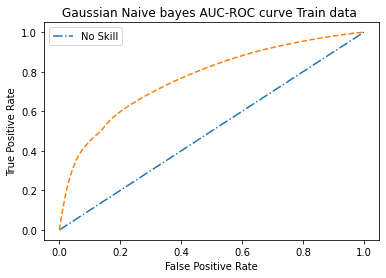


AUC score  0.7665034398402442


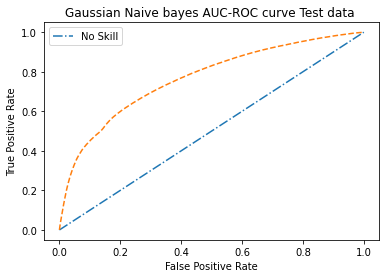

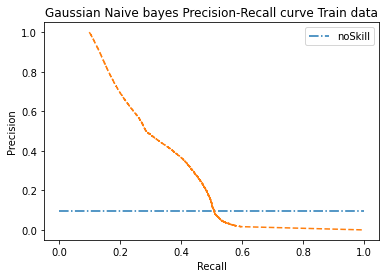

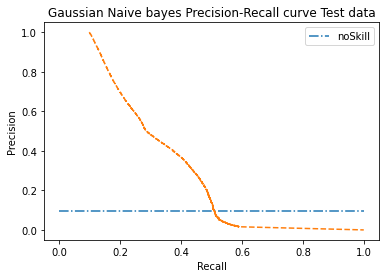

In [ ]:
# printing model performance
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Gaussian Naive bayes AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Gaussian Naive bayes AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="Gaussian Naive bayes Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Gaussian Naive bayes Precision-Recall curve Test data")    

Best Threshold=0.578649, F-Score=0.387


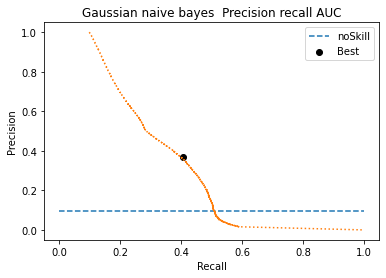

Model Performance
Train: 
True positive rate  0.40427624087750863
False positive rate  0.07466008051114095
False negative  rate  0.5957237591224913
True negative  rate  0.9253399194888591
Precision  0.36987429801443295
Recall 0.40427624087750863
F1 rate 0.3863108873178847
Test: 
True positive rate  0.4045305100594215
False positive rate  0.07435285070051165
False negative  rate  0.5954694899405786
True negative  rate  0.9256471492994883
Precision  0.37098282205194877
Recall 0.4045305100594215
F1 rate 0.3870310515987533


In [ ]:
thresh_gnb=get_optimal_F1(y_test ,y_test_proba, label="Gaussian naive bayes  Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_gnb )

###  Preparing for submission 

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]

# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_gnb_test =gnb.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_gnb_test ,thresh_gnb)

In [ ]:
# save submission csv
submission_log.to_csv("./submission/gnb.csv",index=False)

- score 
- private :0.33670
- public :0.33727

## Bernoulli Nb 

### Hyperpareter tunning Bernouli naive bayes 

In [ ]:
distributions = {'alpha' :list(np.logspace(-9,4, num=20))}
bnb =BernoulliNB()
clf =RandomizedSearchCV(bnb , distributions ,scoring ='f1',n_iter = 30 ,cv =3,verbose=3,return_train_score=True ,n_jobs

- Best hyperparam 
- {'alpha': 428.13323987193957}
- Fitting with best Hyperprameter

In [ ]:
bnb =BernoulliNB(alpha= 428.13323987193957)
bnb.fit(X_train , y_train)

In [ ]:
# making prediction
y_train_pred=bnb.predict(X_train)
y_test_pred=bnb.predict(X_test)
y_train_proba=bnb.predict_proba(X_train)[:,1]
y_test_proba=bnb.predict_proba(X_test)[:,1]

Model Performance
Train: 
True positive rate  0.3598352484469708
False positive rate  0.06127027635466297
False negative  rate  0.6401647515530292
True negative  rate  0.938729723645337
Precision  0.38899051457377537
Recall 0.3598352484469708
F1 rate 0.37384530652504144
Test: 
True positive rate  0.3606551443308298
False positive rate  0.061119510740481095
False negative  rate  0.6393448556691702
True negative  rate  0.938880489259519
Precision  0.39011784973180375
Recall 0.3606551443308298
F1 rate 0.37480839218710327

AUC score  0.7674538578303565


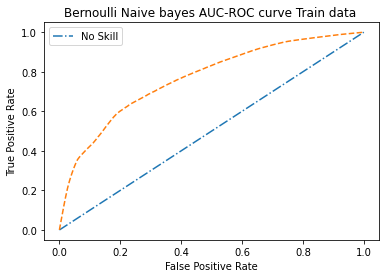


AUC score  0.7676416650938482


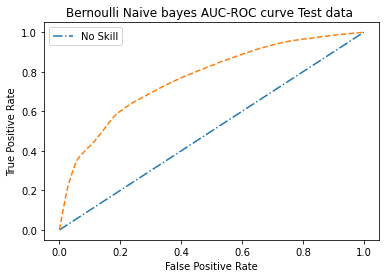

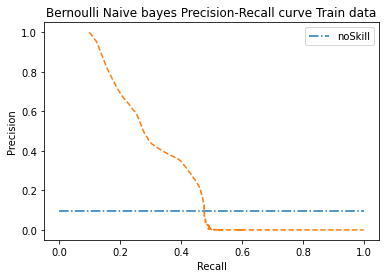

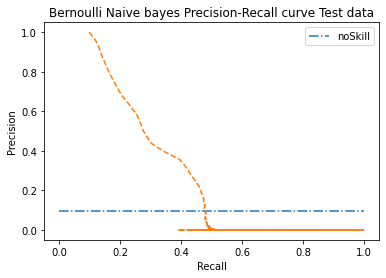

In [ ]:
# printing model performance
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Bernoulli Naive bayes AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Bernoulli Naive bayes AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="Bernoulli Naive bayes Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Bernoulli Naive bayes Precision-Recall curve Test data")    

Best Threshold=0.501781, F-Score=0.375


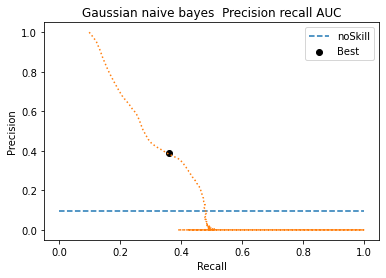

Model Performance
Train: 
True positive rate  0.35973118530930126
False positive rate  0.061225480731424246
False negative  rate  0.6402688146906987
True negative  rate  0.9387745192685758
Precision  0.38909560715083874
Recall 0.35973118530930126
F1 rate 0.3738376494226842
Test: 
True positive rate  0.36058878532862787
False positive rate  0.06107635001517165
False negative  rate  0.6394112146713721
True negative  rate  0.9389236499848284
Precision  0.3902421508268644
Recall 0.36058878532862787
F1 rate 0.37482990211140854


In [ ]:
thresh_bnb=get_optimal_F1(y_test ,y_test_proba, label="Gaussian naive bayes  Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_bnb )


###  Preparing for submission 

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]

# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_bnb_test =bnb.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_bnb_test ,thresh_bnb)
# save submission csv
submission_log.to_csv("./submission/bnb.csv",index=False)

- Score
- private :0.32720
- public :0.32735

# Decision Tree

# Hyper tuning model

In [ ]:
distributions = {'criterion':["gini", "entropy"],'splitter': ["best", "random"] ,'max_depth' :[3,5,10 , 20 , 50,100] ,
                 'min_samples_split' :[3,5,10 , 20 , 50,100,150 ,200],
'min_samples_leaf' :[3,5,10 , 20 , 50,100,150 ,200]}

In [ ]:
decisionTree =DecisionTreeClassifier()
clf =RandomizedSearchCV(decisionTree , distributions ,scoring ='f1',n_iter = 30 ,cv =3,verbose=3,return_train_score=True ,n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

## Hyperparam tuned best prameters
- {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 100, 'criterion': 'gini'}

### Training with tuned parameter

In [ ]:
param ={'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 100, 'criterion': 'gini'}
decisionTree =DecisionTreeClassifier(**param)

In [ ]:
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=10)

In [ ]:
# making prediction
y_train_pred=decisionTree.predict(X_train)
y_test_pred=decisionTree.predict(X_test)
y_train_proba=decisionTree.predict_proba(X_train)[:,1]
y_test_proba=decisionTree.predict_proba(X_test)[:,1]


Model Performance
Train: 
True positive rate  0.3330729241289237
False positive rate  0.01456037591702281
False negative  rate  0.6669270758710764
True negative  rate  0.9854396240829771
Precision  0.7126211649909006
Recall 0.3330729241289237
F1 rate 0.4539660646250078
Test: 
True positive rate  0.2078424275329533
False positive rate  0.028365751833676876
False negative  rate  0.7921575724670468
True negative  rate  0.9716342481663232
Precision  0.44267560934870037
Recall 0.2078424275329533
F1 rate 0.2828723203362973

AUC score  0.9330946821769641


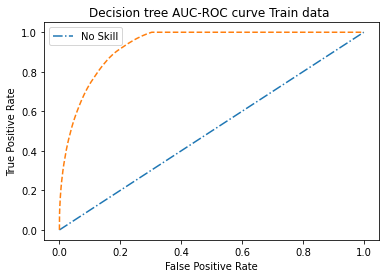


AUC score  0.7085283428959789


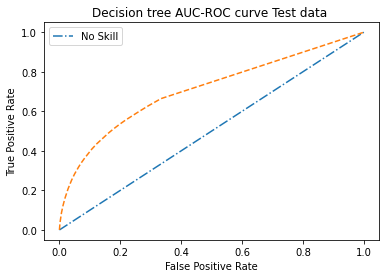

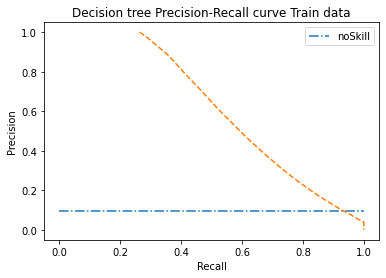

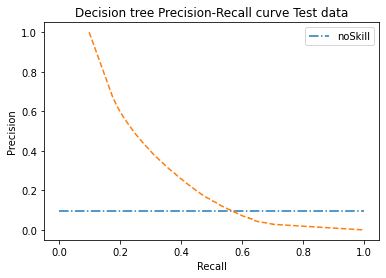

In [ ]:
# printing model performance
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )

plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Decision tree AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Decision tree AUC-ROC curve Test data ")

plot_Precision_Recall(y_train ,y_train_proba ,title="Decision tree Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Decision tree Precision-Recall curve Test data")   

- Finding the optimal threshold from precision recall to maximize f1 score 

Best Threshold=0.277778, F-Score=0.342


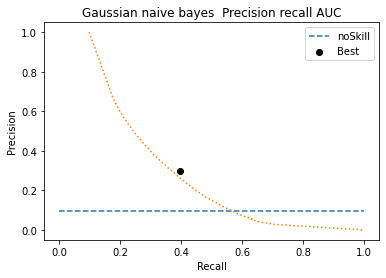

Model Performance
Train: 
True positive rate  0.6473390754065627
False positive rate  0.0702125617717748
False negative  rate  0.3526609245934374
True negative  rate  0.9297874382282252
Precision  0.49985850556253647
Recall 0.6473390754065627
F1 rate 0.5641189420075571
Test: 
True positive rate  0.3939794287093174
False positive rate  0.09859086771368483
False negative  rate  0.6060205712906825
True negative  rate  0.9014091322863151
Precision  0.30225389919933354
Recall 0.3939794287093174
F1 rate 0.3420744562441892


In [ ]:
thresh_dt=get_optimal_F1(y_test ,y_test_proba, label="Gaussian naive bayes  Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_dt )

###  Preparing for submission 

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]

# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_dt_test =decisionTree.predict_proba(test)[:,1]


ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:

# generate submission csv
submission_log=generate_SubmissionCsv(test_temp ,predict_dt_test ,thresh_dt)

# save submission csv
submission_log.to_csv("./submission/decisionTree2.csv",index=False)


## Score after submission 
- public score :0.27510
- private score :0.27767



# Random forest 


### HyperParameter tunning Random forest 

In [ ]:
distributions = {
'max_depth': [10, 20, 30, 40 ,50, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [20 , 50,100,150 ,200],
'min_samples_split': [10 , 20 , 50,100,150 ,200],
'n_estimators': [10 ,20,30,40,50,60,70 ]
}

In [ ]:
rf = RandomForestClassifier() 

In [ ]:
rf=RandomizedSearchCV(estimator = rf, param_distributions = distributions,scoring ='f1', n_iter = 50, cv = 3, random_state=0, n_jobs = -1)

In [ ]:
rf.fit(X_train , y_train)

### After hyper param tunning best param 
- {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 50}

In [ ]:
rf = RandomForestClassifier(n_estimators= 20, min_samples_split= 10, min_samples_leaf= 20, max_features= 'sqrt', max_depth= 50)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=20,
                       min_samples_split=10, n_estimators=20)

In [ ]:
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)
y_train_proba=rf.predict_proba(X_train)[:,1]
y_test_proba=rf.predict_proba(X_test)[:,1]

Model Performance
Train: 
True positive rate  0.16024365855828818
False positive rate  0.007379179746361949
False negative  rate  0.8397563414417119
True negative  rate  0.9926208202536381
Precision  0.7018502249202375
Recall 0.16024365855828818
F1 rate 0.26091600916451185
Test: 
True positive rate  0.1428829970138449
False positive rate  0.009075523421886935
False negative  rate  0.8571170029861551
True negative  rate  0.9909244765781131
Precision  0.630540691638048
Recall 0.1428829970138449
F1 rate 0.23297332389046274

AUC score  0.8745674142279063


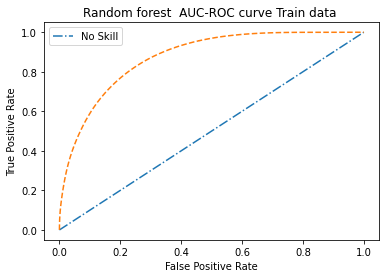


AUC score  0.8077957445905996


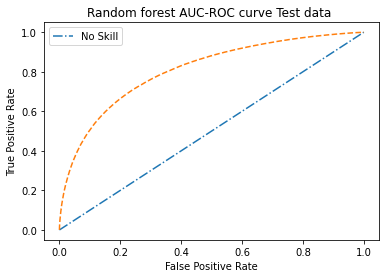

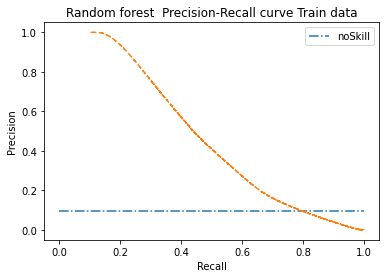

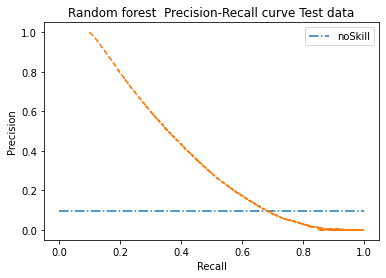

In [ ]:
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )
plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Random forest  AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Random forest AUC-ROC curve Test data ")
plot_Precision_Recall(y_train ,y_train_proba ,title="Random forest  Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Random forest  Precision-Recall curve Test data")    

- Finding the optimal threshold from precision recall to maximize f1 score

Best Threshold=0.208533, F-Score=0.418


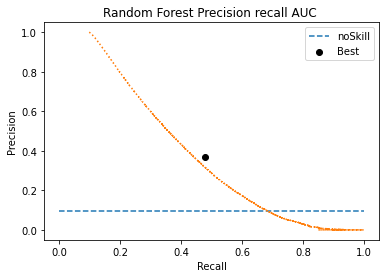

Model Performance
Train: 
True positive rate  0.5405793451261501
False positive rate  0.08196683521701109
False negative  rate  0.45942065487384987
True negative  rate  0.9180331647829889
Precision  0.416882996045592
Recall 0.5405793451261501
F1 rate 0.47074088934037883
Test: 
True positive rate  0.4789430820740205
False positive rate  0.08808907850543564
False negative  rate  0.5210569179259795
True negative  rate  0.9119109214945643
Precision  0.37082603517130247
Recall 0.4789430820740205
F1 rate 0.41800663402306115


In [ ]:
thresh_rf=get_optimal_F1(y_test ,y_test_proba, label="Random Forest Precision recall AUC ")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_rf )

### Prepare for submission

In [ ]:
# reading test data
test =pd.read_parquet('test.gzip')
test_temp = test[["order_id", "product_id"]]

# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
test =ohe_Test(test , test_preprocessing_object )
# making prediction on test data
predict_rf_test =rf.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length
(4833292, 3)
(4833292, 24)


In [ ]:
# generate submission csv
submission_rf=generate_SubmissionCsv(test_temp,predict_rf_test ,thresh_rf)
# save submission csv 
submission_rf.to_csv("./submission/randomforest2.csv",index=False)

# Submission score 
- private score :0.34993
- public :0.35191

# Xgboost 

### Hypertuning Xgboost 

In [26]:
def optimizeXg(params,X_train =X_train,y_train=y_train , X_test =X_test , y_test =y_test):
  kf = StratifiedKFold(n_splits =3)
  print(params)
  xgboost=xgb.XGBClassifier(**params)
  watchlist =[(X_test , y_test)]
  f1s =[]
  for idx in kf.split(X=X_train ,y =y_train):
    train_idx , test_idx=idx[0] ,idx[1]
    xtrain =X_train.iloc[train_idx ,:]
    ytrain =y_train[train_idx]

    xtest =X_train.iloc[test_idx ,:]
    ytest =y_train[test_idx]


    xgboost.fit(xtrain , ytrain ,eval_set=watchlist, eval_metric ='logloss',early_stopping_rounds=50)
    
    y_pred_test=xgboost.predict(xtest)

    f1=f1_score(ytest , y_pred_test)
    print(f1)
    f1s.append(f1)

  return -1.0 *np.mean(f1s)

In [30]:
# define parameter space

param_space ={
    'max_depth' :scope.int(hp.quniform('max_depth' ,3 , 12,2)),
    'eta' :hp.uniform('eta' ,0.1 ,0.2 ),
    'subsample': hp.uniform('subsample' , 0.5 ,0.8 ),
    'colsample_bytree' :hp.uniform('colsample_bytree' , 0.5 ,0.8 ),
    'gamma' :scope.int(hp.quniform('gamma' ,0 ,2 ,1)),
    'n_estimators' :scope.int(hp.quniform('n_estimators' ,50 ,5000 ,50)),
    'scale_pos_weight' :scope.int(hp.quniform('scale_pos_weight' ,5,10 ,2)),
    'tree_method':hp.choice('tree_method',['gpu_hist']),
} 

optimization_function = partial(optimizeXg ,X_train =X_train,y_train =y_train , X_test =X_test , y_test =y_test)
trail = Trials()
results =fmin(fn =optimization_function , space= param_space , algo =tpe.suggest  , max_evals=100 ,trials=trail )

Streaming output truncated to the last 5000 lines.
[72]	validation_0-logloss:0.494626

[73]	validation_0-logloss:0.494594

[74]	validation_0-logloss:0.494542

[75]	validation_0-logloss:0.494437

[76]	validation_0-logloss:0.494527

[77]	validation_0-logloss:0.494367

[78]	validation_0-logloss:0.494341

[79]	validation_0-logloss:0.494352

[80]	validation_0-logloss:0.494324

[81]	validation_0-logloss:0.49424

[82]	validation_0-logloss:0.494204

[83]	validation_0-logloss:0.494205

[84]	validation_0-logloss:0.494011

[85]	validation_0-logloss:0.493939

[86]	validation_0-logloss:0.493869

[87]	validation_0-logloss:0.493687

[88]	validation_0-logloss:0.493616

[89]	validation_0-logloss:0.493549

[90]	validation_0-logloss:0.493542

[91]	validation_0-logloss:0.493548

[92]	validation_0-logloss:0.493537

[93]	validation_0-logloss:0.493489

[94]	validation_0-logloss:0.493513

[95]	validation_0-logloss:0.493473

[96]	validation_0-logloss:0.493456

[97]	validation_0-logloss:0.493496

[98]	validatio

### Best pramameter after different trails:
-best_params ={'colsample_bytree': 0.7736610394413841, 'eta': 0.1, 'gamma': 1, 'max_depth': 5, 'scale_pos_weight':9,'n_estimators': 1800, 'subsample': 0.598690048807158, 'tree_method': 'gpu_hist'}

## Training Xgboost with best hyperparams

In [31]:
best_params ={'colsample_bytree': 0.7736610394413841, 'eta': 0.1, 'gamma': 1, 'max_depth': 5, 'scale_pos_weight':9,'n_estimators': 1800, 'subsample': 0.598690048807158, 'tree_method': 'gpu_hist'}

In [32]:
#Train xgboost
xgboost=xgb.XGBClassifier(**best_params)
watchlist =[(X_test , y_test)]

In [33]:
xgboost.fit(X_train , y_train ,eval_set=watchlist, eval_metric ='logloss',early_stopping_rounds=50)

[0]	validation_0-logloss:0.669608
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.650045
[2]	validation_0-logloss:0.631741
[3]	validation_0-logloss:0.616471
[4]	validation_0-logloss:0.604952
[5]	validation_0-logloss:0.60058
[6]	validation_0-logloss:0.590687
[7]	validation_0-logloss:0.581798
[8]	validation_0-logloss:0.575443
[9]	validation_0-logloss:0.568666
[10]	validation_0-logloss:0.563949
[11]	validation_0-logloss:0.558646
[12]	validation_0-logloss:0.555224
[13]	validation_0-logloss:0.551293
[14]	validation_0-logloss:0.548317
[15]	validation_0-logloss:0.545425
[16]	validation_0-logloss:0.543202
[17]	validation_0-logloss:0.542047
[18]	validation_0-logloss:0.540385
[19]	validation_0-logloss:0.538414
[20]	validation_0-logloss:0.536799
[21]	validation_0-logloss:0.535436
[22]	validation_0-logloss:0.534562
[23]	validation_0-logloss:0.533729
[24]	validation_0-logloss:0.532972
[25]	validation_0-logloss:0.532188
[26]	validation_0-logloss:0.53150

[230]	validation_0-logloss:0.5232
[231]	validation_0-logloss:0.523176
[232]	validation_0-logloss:0.523144
[233]	validation_0-logloss:0.523153
[234]	validation_0-logloss:0.523124
[235]	validation_0-logloss:0.52304
[236]	validation_0-logloss:0.523035
[237]	validation_0-logloss:0.523057
[238]	validation_0-logloss:0.522995
[239]	validation_0-logloss:0.522962
[240]	validation_0-logloss:0.523046
[241]	validation_0-logloss:0.522992
[242]	validation_0-logloss:0.522976
[243]	validation_0-logloss:0.522957
[244]	validation_0-logloss:0.522965
[245]	validation_0-logloss:0.522964
[246]	validation_0-logloss:0.523028
[247]	validation_0-logloss:0.523021
[248]	validation_0-logloss:0.523027
[249]	validation_0-logloss:0.523037
[250]	validation_0-logloss:0.523071
[251]	validation_0-logloss:0.52309
[252]	validation_0-logloss:0.523089
[253]	validation_0-logloss:0.523115
[254]	validation_0-logloss:0.523191
[255]	validation_0-logloss:0.523142
[256]	validation_0-logloss:0.523067
[257]	validation_0-logloss:0.523

[459]	validation_0-logloss:0.521917
[460]	validation_0-logloss:0.521975
[461]	validation_0-logloss:0.521922
[462]	validation_0-logloss:0.521934
[463]	validation_0-logloss:0.521964
[464]	validation_0-logloss:0.521934
[465]	validation_0-logloss:0.521963
[466]	validation_0-logloss:0.521958
[467]	validation_0-logloss:0.521962
[468]	validation_0-logloss:0.52195
[469]	validation_0-logloss:0.521919
[470]	validation_0-logloss:0.521894
[471]	validation_0-logloss:0.521906
[472]	validation_0-logloss:0.521886
[473]	validation_0-logloss:0.521881
[474]	validation_0-logloss:0.521877
[475]	validation_0-logloss:0.521919
[476]	validation_0-logloss:0.521844
[477]	validation_0-logloss:0.521847
[478]	validation_0-logloss:0.521774
[479]	validation_0-logloss:0.521777
[480]	validation_0-logloss:0.521835
[481]	validation_0-logloss:0.521784
[482]	validation_0-logloss:0.521822
[483]	validation_0-logloss:0.521834
[484]	validation_0-logloss:0.521851
[485]	validation_0-logloss:0.521789
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.520887
[689]	validation_0-logloss:0.520834
[690]	validation_0-logloss:0.520747
[691]	validation_0-logloss:0.520774
[692]	validation_0-logloss:0.520755
[693]	validation_0-logloss:0.520716
[694]	validation_0-logloss:0.520721
[695]	validation_0-logloss:0.520663
[696]	validation_0-logloss:0.52072
[697]	validation_0-logloss:0.520709
[698]	validation_0-logloss:0.520687
[699]	validation_0-logloss:0.520647
[700]	validation_0-logloss:0.520679
[701]	validation_0-logloss:0.520689
[702]	validation_0-logloss:0.520699
[703]	validation_0-logloss:0.520679
[704]	validation_0-logloss:0.520671
[705]	validation_0-logloss:0.520697
[706]	validation_0-logloss:0.520655
[707]	validation_0-logloss:0.520656
[708]	validation_0-logloss:0.520695
[709]	validation_0-logloss:0.520651
[710]	validation_0-logloss:0.520568
[711]	validation_0-logloss:0.52052
[712]	validation_0-logloss:0.520509
[713]	validation_0-logloss:0.52053
[714]	validation_0-logloss:0.520572
[715]	validation_0-logloss:0.52

XGBClassifier(colsample_bytree=0.7736610394413841, eta=0.1, gamma=1,
              max_depth=5, n_estimators=1800, scale_pos_weight=9,
              subsample=0.598690048807158, tree_method='gpu_hist')

In [34]:
# making predictions
y_train_proba=xgboost.predict_proba(X_train)[:,1]
y_test_proba=xgboost.predict_proba(X_test)[:,1]
y_train_pred=np.where(y_train_proba>0.5,1 ,0)
y_test_pred=np.where(y_test_proba>0.5,1 ,0)

In [45]:
import joblib
def serialize_model(model , filename):
    """
    Serialize trained model 
    """
    joblib.dump(model, filename)
    
def deserialize_model( filename):
    """
    DeSerialize trained model 
    """
    return joblib.load(filename)

def pickle_dictionary(location  ,file):
    with open(os.path.join(location ,), 'wb') as handle:
        pickle.dump(file, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
# serialize_model(xgboost ,'final_model_pkl/xgboost.pkl')

In [37]:
X_train.head(1)

,ur_pr_reordered,reordered_last,order_number,ttl_cnt_product_user,Avg_no_prod_perOrder,days_since_prior_order,max_hour_of_day,usr_ro_ratio,max_dow,product_name_length,isglutenfree,is_organic,product_is_rare
index,,,,,,,,,,,,,
812828,-0.404576,0.134902,-0.826947,-0.691118,0.209591,1.226677,0.097868,-0.988841,0.096851,-0.461035,0,0,0


Model Performance
Train: 
Accuracy 0.7568796270292849
True positive rate  0.7087378347929822
False positive rate  0.23790170761242763
False negative  rate  0.29126216520701775
True negative  rate  0.7620982923875724
Precision  0.24410927011102274
Recall 0.7087378347929822
F1 rate 0.36314215504451036
Test: 
Accuracy 0.7556652681846421
True positive rate  0.7060477181552197
False positive rate  0.2389560859238488
False negative  rate  0.2939522818447803
True negative  rate  0.7610439140761512
Precision  0.24259496478333148
Recall 0.7060477181552197
F1 rate 0.3611130395074413

AUC score  0.8114635662651755


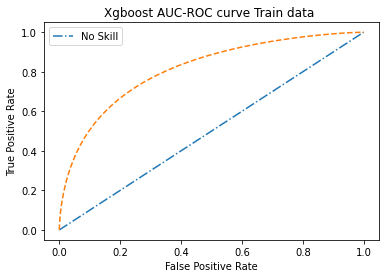


AUC score  0.8082424536396517


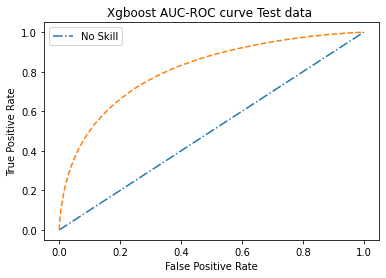

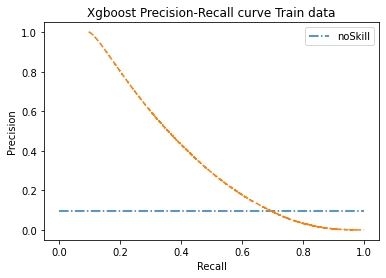

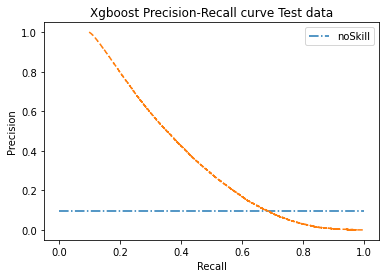

In [62]:
printModelPerformance(y_train ,y_train_pred,y_test ,y_test_pred  )
plotAUC_ROC_Curve(y_train ,y_train_proba , title ="Xgboost AUC-ROC curve Train data ")
plotAUC_ROC_Curve(y_test ,y_test_proba , title ="Xgboost AUC-ROC curve Test data ")
plot_Precision_Recall(y_train ,y_train_proba ,title="Xgboost Precision-Recall curve Train data")
plot_Precision_Recall(y_test ,y_test_proba ,title="Xgboost Precision-Recall curve Test data")    

- Finding the optimal threshold from precision recall to maximize f1 score

Best Threshold=0.692886, F-Score=0.415


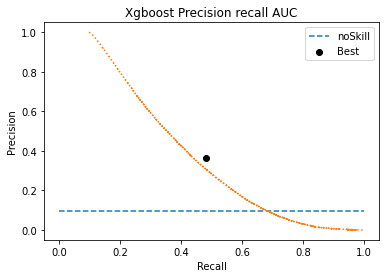

Model Performance
Train: 
Accuracy 0.8682804088895602
True positive rate  0.482855975109304
False positive rate  0.08993882127674392
False negative  rate  0.517144024890696
True negative  rate  0.9100611787232561
Precision  0.3678805177136764
Recall 0.482855975109304
F1 rate 0.41759888661861927
Test: 
Accuracy 0.867562316622545
True positive rate  0.4810907006907369
False positive rate  0.09054335429462296
False negative  rate  0.5189092993092631
True negative  rate  0.909456645705377
Precision  0.365474510091474
Recall 0.4810907006907369
F1 rate 0.41538770056957725


In [63]:
thresh_xg=get_optimal_F1(y_test ,y_test_proba, label="Xgboost Precision recall AUC")
Model_Perpormance_after_Thresholding(y_train,y_train_proba ,y_test, y_test_proba , thresh_xg )

In [ ]:
here1

Preparing data for submission in kaggle

In [51]:
# reading test data
test =pd.read_parquet(dir+'test.gzip')
test_temp = test[["order_id", "product_id"]]
# preparing test data
test.drop(columns =["order_id",'ur_pr_count' ,"user_id" ,'product_id' ,'department_id' ,'aisle_id' ,'ur_pr_count'] , inplace =True)
# standardizing test data 
test , test_preprocessing_object=standardize(None, test ,test_preprocessing_object , flag ='test')
# One hot encoding test data 
# test =ohe_Test(test , test_preprocessing_object )
response_code_test( test ,reponse_dict)
# making prediction on test data
predict_xg_test =xgboost.predict_proba(test)[:,1]

ur_pr_reordered
order_number
ttl_cnt_product_user
Avg_no_prod_perOrder
days_since_prior_order
usr_ro_ratio
product_name_length


In [57]:
# pickle_dictionary('final_model_pkl\reponse_dict.pkl'  ,reponse_dict)
# pickle_dictionary(os.path.join('final_model_pkl' ,'reponse_dict.pkl')  ,reponse_dict)

In [47]:
import pickle

In [56]:
# pickle_dictionary(os.path.join('final_model_pkl' ,'test_preprocessing_object_dict.pkl')  ,test_preprocessing_object)

In [65]:
submission_xg=generate_SubmissionCsv_colob(test_temp ,predict_xg_test ,thresh_xg)

In [66]:
submission_xg.to_csv(dir+"xg_boost_850_.csv",index=False)

# Submission Score
- private : 0.35466
- public :0.35528

# Model performance comparision on test data 

In [68]:
index  =['AUC','TPR' ,'FPR' ,'FNR' ,'TNR' ,'Precision','Recall' ,'F1','thresh' ,'private_lb','public_lb']
data ={
 'Knn':[0.720,0.276 ,0.043,0.723,0.956,0.407,0.276,0.329,0.661 ,0.308,0.309],
'SVC':[0.61,0.376,0.219,0.623,0.623,0.780,0.155,0.376,0.220 ,0.198,0.202],
'Logistic_Regression':[0.790,0.441,0.083,0.558,0.916,0.363,0.441,0.398,0.661 ,0.34327,0.34449],
'Gaussion_NB':[0.766,0.404,0.0743,0.595,0.925,0.370,0.404,0.387,0.578 ,0.33670,0.333727],
'Bernoulli_NB':[0.767,0.3605,0.0610,0.63,0.93,0.390,0.360,0.374,0.501 ,0.32720,0.32735],
'Decision_tree':[0.708,0.3939,0.0985,0.6060,0.9014,0.3022,0.3939,0.3420,0.2777 ,0.27510,0.27767],
'Random_Forest':[0.8077,0.4789,0.0880,0.5210,0.9119,0.3708,0.4789,0.4180,0.2085 ,0.34993,0.35191],
'XGboost':[0.8082,0.4810,0.0905,0.5189,0.9094,0.3654,0.4810,0.4153,0.692886 ,0.35466,0.35528]
}

performance=pd.DataFrame(data , index=index)

In [69]:
performance

,Knn,SVC,Logistic_Regression,Gaussion_NB,Bernoulli_NB,Decision_tree,Random_Forest,XGboost
AUC,0.720,0.610,0.79000,0.766000,0.76700,0.70800,0.80770,0.808200
TPR,0.276,0.376,0.44100,0.404000,0.36050,0.39390,0.47890,0.481000
FPR,0.043,0.219,0.08300,0.074300,0.06100,0.09850,0.08800,0.090500
FNR,0.723,0.623,0.55800,0.595000,0.63000,0.60600,0.52100,0.518900
TNR,0.956,0.623,0.91600,0.925000,0.93000,0.90140,0.91190,0.909400
Precision,0.407,0.780,0.36300,0.370000,0.39000,0.30220,0.37080,0.365400
Recall,0.276,0.155,0.44100,0.404000,0.36000,0.39390,0.47890,0.481000
F1,0.329,0.376,0.39800,0.387000,0.37400,0.34200,0.41800,0.415300
thresh,0.661,0.220,0.66100,0.578000,0.50100,0.27770,0.20850,0.692886
private_lb,0.308,0.198,0.34327,0.336700,0.32720,0.27510,0.34993,0.354660


- Auc : Xgboost has the highiest AUC
- TPR/Recall :Xgboost has highiest TPR/Recall
- FPR :KNN has the lowest FPR
- FNR :Xgboost has the lowest FNR
- TNR :KNN  has highest TNR
- Precision :Bernouli NB  has highest Precision
- F1 : Random Forest has highest F1
- Private lb: Xgboost has highest lb
- Public lb :Xgboost has highest lb
- Over all Xgboost is performing best